In [ ]:
# Peak detection and gaussian on the histogram of the image heights

# H
# |          =               
# |          = =            
# |  =     = = =              
# |  =     = = = =             
# |= =   = = = = =      =        
# |= = = = = = = = =  = = =         
# \ - - - - - - - - - - - - X



In [ ]:
# Identify the background
#   Generate mask
#   Estimate polynomial background
# Determine 1-D background offsets from the raw data within the mask
# Subtract the 1-D offsets from the raw data followed by a single masked background flattening.

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pySPM
import os
import glob
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# Median
def median_flattening(image: np.ndarray, mask: np.ndarray = None):
    if mask is not None:
        read_matrix = np.ma.masked_array(image, mask=mask, fill_value=np.nan).filled()
    else:
        read_matrix = image

    for j in range(image.shape[0]):
        # Get the median of the row
        m = np.nanmedian(read_matrix[j, :])
        # print(m)
        image[j, :] -= m
    return image

# Median differences
def median_differences_flattening(image: np.ndarray, mask: np.ndarray = None):
    if mask is not None:
        read_matrix = np.ma.masked_array(image, mask=mask, fill_value=np.nan).filled()
    else:
        read_matrix = image

    for j in range(read_matrix.shape[0]):
        if j > 0:
            median_height_diff_above = np.nanmedian(read_matrix[j, :] - read_matrix[j-1, :])
            # print(f'median difference in height: {median_height_diff_above}')
            image[j, :] -= median_height_diff_above
    return image

def remove_plane_tilt(image: np.ndarray, mask: np.ndarray = None):
    if mask is not None:
        read_matrix = np.ma.masked_array(image, mask=mask, fill_value=np.nan).filled()
    else:
        read_matrix = image
    
    # Get x-slope
    # Get median LHS x value
    x_lhs_median = np.nanmedian(read_matrix[:, 0])
    x_rhs_median = np.nanmedian(read_matrix[:, image.shape[1]-1])
    dx = (x_rhs_median - x_lhs_median) / (read_matrix.shape[1] - 1)
    # print(f'avg x left: {x_lhs_median}')
    # print(f'avg x right: {x_rhs_median}')
    # print(f'dx: {dx}')
    y_top_median = np.nanmedian(read_matrix[0, :])
    y_bottom_median = np.nanmedian(read_matrix[image.shape[0]-1, :])
    dy = (y_bottom_median - y_top_median) / (read_matrix.shape[0] - 1)
    # print(f'avg y top: {y_top_median}')
    # print(f'avg y bot: {y_bottom_median}')
    # print(f'dy: {dy}')

    for j in range(image.shape[0]):
        for i in range(image.shape[1]):
            image[j, i] -= (dx * i + dy * j)
            # print(f'subbing: {dx} * {i} + {dy} * {j}')
    
    return image

def add_ring(image: np.ndarray, outer_size: int = 200, inner_size: int = 100, centre: tuple = (0, 0), height: int = 10):
    cx = centre[0]
    cy = centre[1]
    for i in range(-outer_size, outer_size):
        for j in range(-outer_size, outer_size):
                if j+cy < image.shape[0] - 1:
                    if i+cx < image.shape[1] - 1:
                        if ((i)**2 + (j)**2) < outer_size**2 and i**2 + j**2 > inner_size**2:             
                            image[i+cx, j+cy] += height
    return image

# Add scan lines
def add_scan_lines(image: np.ndarray, magnitude: int = 10):
    for j in range(image.shape[0]):
        image[j, :] += (np.random.random() - 0.5) * magnitude
    return image

# Add random noise
def add_random_noise(image: np.ndarray, magnitude: int = 1):
    for j in range(image.shape[0]):
        for i in range(image.shape[1]):
            image[j, i] += (np.random.random() - 0.5) * magnitude
    return image

# Add slant 
def add_slant(image: np.ndarray, magnitude_x: float = 0.01, magnitude_y: float = 0.03):
    for j in range(image.shape[0]):
        for i in range(image.shape[1]):
            image[j, i] += (magnitude_y*j) + (magnitude_x*i)
    return image

def plot_histogram(image: np.ndarray, title: str = ''):
    plt.figure(figsize=(4, 4), dpi=80)
    plt.hist(image.flatten(), bins=len(np.unique(image)))
    plt.title(title)
    plt.show()
    

# Masking 
def mask_image(image: np.ndarray, std_dev_multiplier: float = 1.0):
    # Calculate threshold value
    mean = np.mean(image)
    std_dev = np.std(image)
    # print(f'mean: {mean} std_dev: {std_dev}')
    threshold = mean + std_dev_multiplier * std_dev
    # print(f'threshold: {threshold}')

    mask = image > threshold
    # masked_image = np.ma.masked_array(original_image, mask=mask, fill_value=np.nan).filled()

    return mask


In [4]:
def flatten(data: np.ndarray, filename: str, save_path: Path):
    
    # image = np.ones((1024, 1024), dtype=np.float64)
    # im_array = np.array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
    # for i in range(20):
    #     image = add_ring(image, outer_size=200, inner_size=190, centre=(np.random.randint(0,image.shape[1]), np.random.randint(0, image.shape[0])))

    # plot_histogram(image)
    # print('add noise')
    # image = add_random_noise(image, magnitude=10)
    # plot_histogram(image)
    # print('add scan')
    # image = add_scan_lines(image)
    # plot_histogram(image)
    # print('add slant')
    # image = add_slant(image)
    # plot_histogram(image)

    image = np.copy(data)

    # print(f'shape: {image.shape}')

    original_image = np.copy(image)

    # plt.imshow(image)
    # plt.title('original')
    # plt.colorbar()
    # plt.show()

    # plot_histogram(image)

    # im_array = median_differences_flattening(im_array)
    image = remove_plane_tilt(image)
    image = median_flattening(image)

    mask = mask_image(image, std_dev_multiplier=0.4)
    # TRY OTSU

    # print('--- mask ---')
    # plt.imshow(mask)

    # print('--- flatten 1 ----')
    # plt.imshow(image)
    # plt.title('flatten 1')
    # plt.colorbar()
    # plot_histogram(image, title='flatten 1')
    # print('---- ----')

    # print('---- Comparison ----')
    # plt.imshow(original_image)
    # plt.title('original image')
    # plt.colorbar()
    # plt.show()
    # plot_histogram(original_image, title='original_image')
    # print('---- flatten 2 ----')
    image_better = np.copy(original_image)
    image_better = remove_plane_tilt(image_better, mask)
    image_better = median_flattening(image_better, mask)
    # print('---- ----')
    # print('---- flattened 2 ----')
    # plt.imshow(image_better) 
    # plt.title('flatten 2')
    # plt.colorbar()
    # plot_histogram(image_better, title='flatten 2')
    # print('---- ----')


    # Plot the images  
    fig, ax = plt.subplots(3, 2)
    im1 = ax[0, 0].imshow(original_image, interpolation='None')
    ax[0, 0].set_title('original image')
    divider = make_axes_locatable(ax[0, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax[0, 1].hist(original_image.flatten(), bins=len(np.unique(original_image)), log=True)
    ax[0, 1].set_title('original image')

    im2 = ax[1, 0].imshow(image, interpolation='None')
    ax[1, 0].set_title('flattened image')
    divider = make_axes_locatable(ax[1, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    ax[1, 1].hist(image.flatten(), bins=len(np.unique(original_image)), log=True)
    ax[1, 1].set_title('flattened image')

    im2 = ax[2, 0].imshow(image_better, interpolation='None')
    ax[2, 0].set_title('flattened image with mask')
    divider = make_axes_locatable(ax[2, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    ax[2, 1].hist(image_better.flatten(), bins=len(np.unique(original_image)), log=True)
    ax[2, 1].set_title('flattened image with mask')

    fig.tight_layout()
    fig.savefig(f'{Path(save_path) / filename}.png')
    fig.suptitle(filename, size=16, y=1.12)
    plt.show()

    # TODO:
    # measure the amount of noise and type of noise
    # do image in subtracted by image out 

pySPM version: 0.2.23


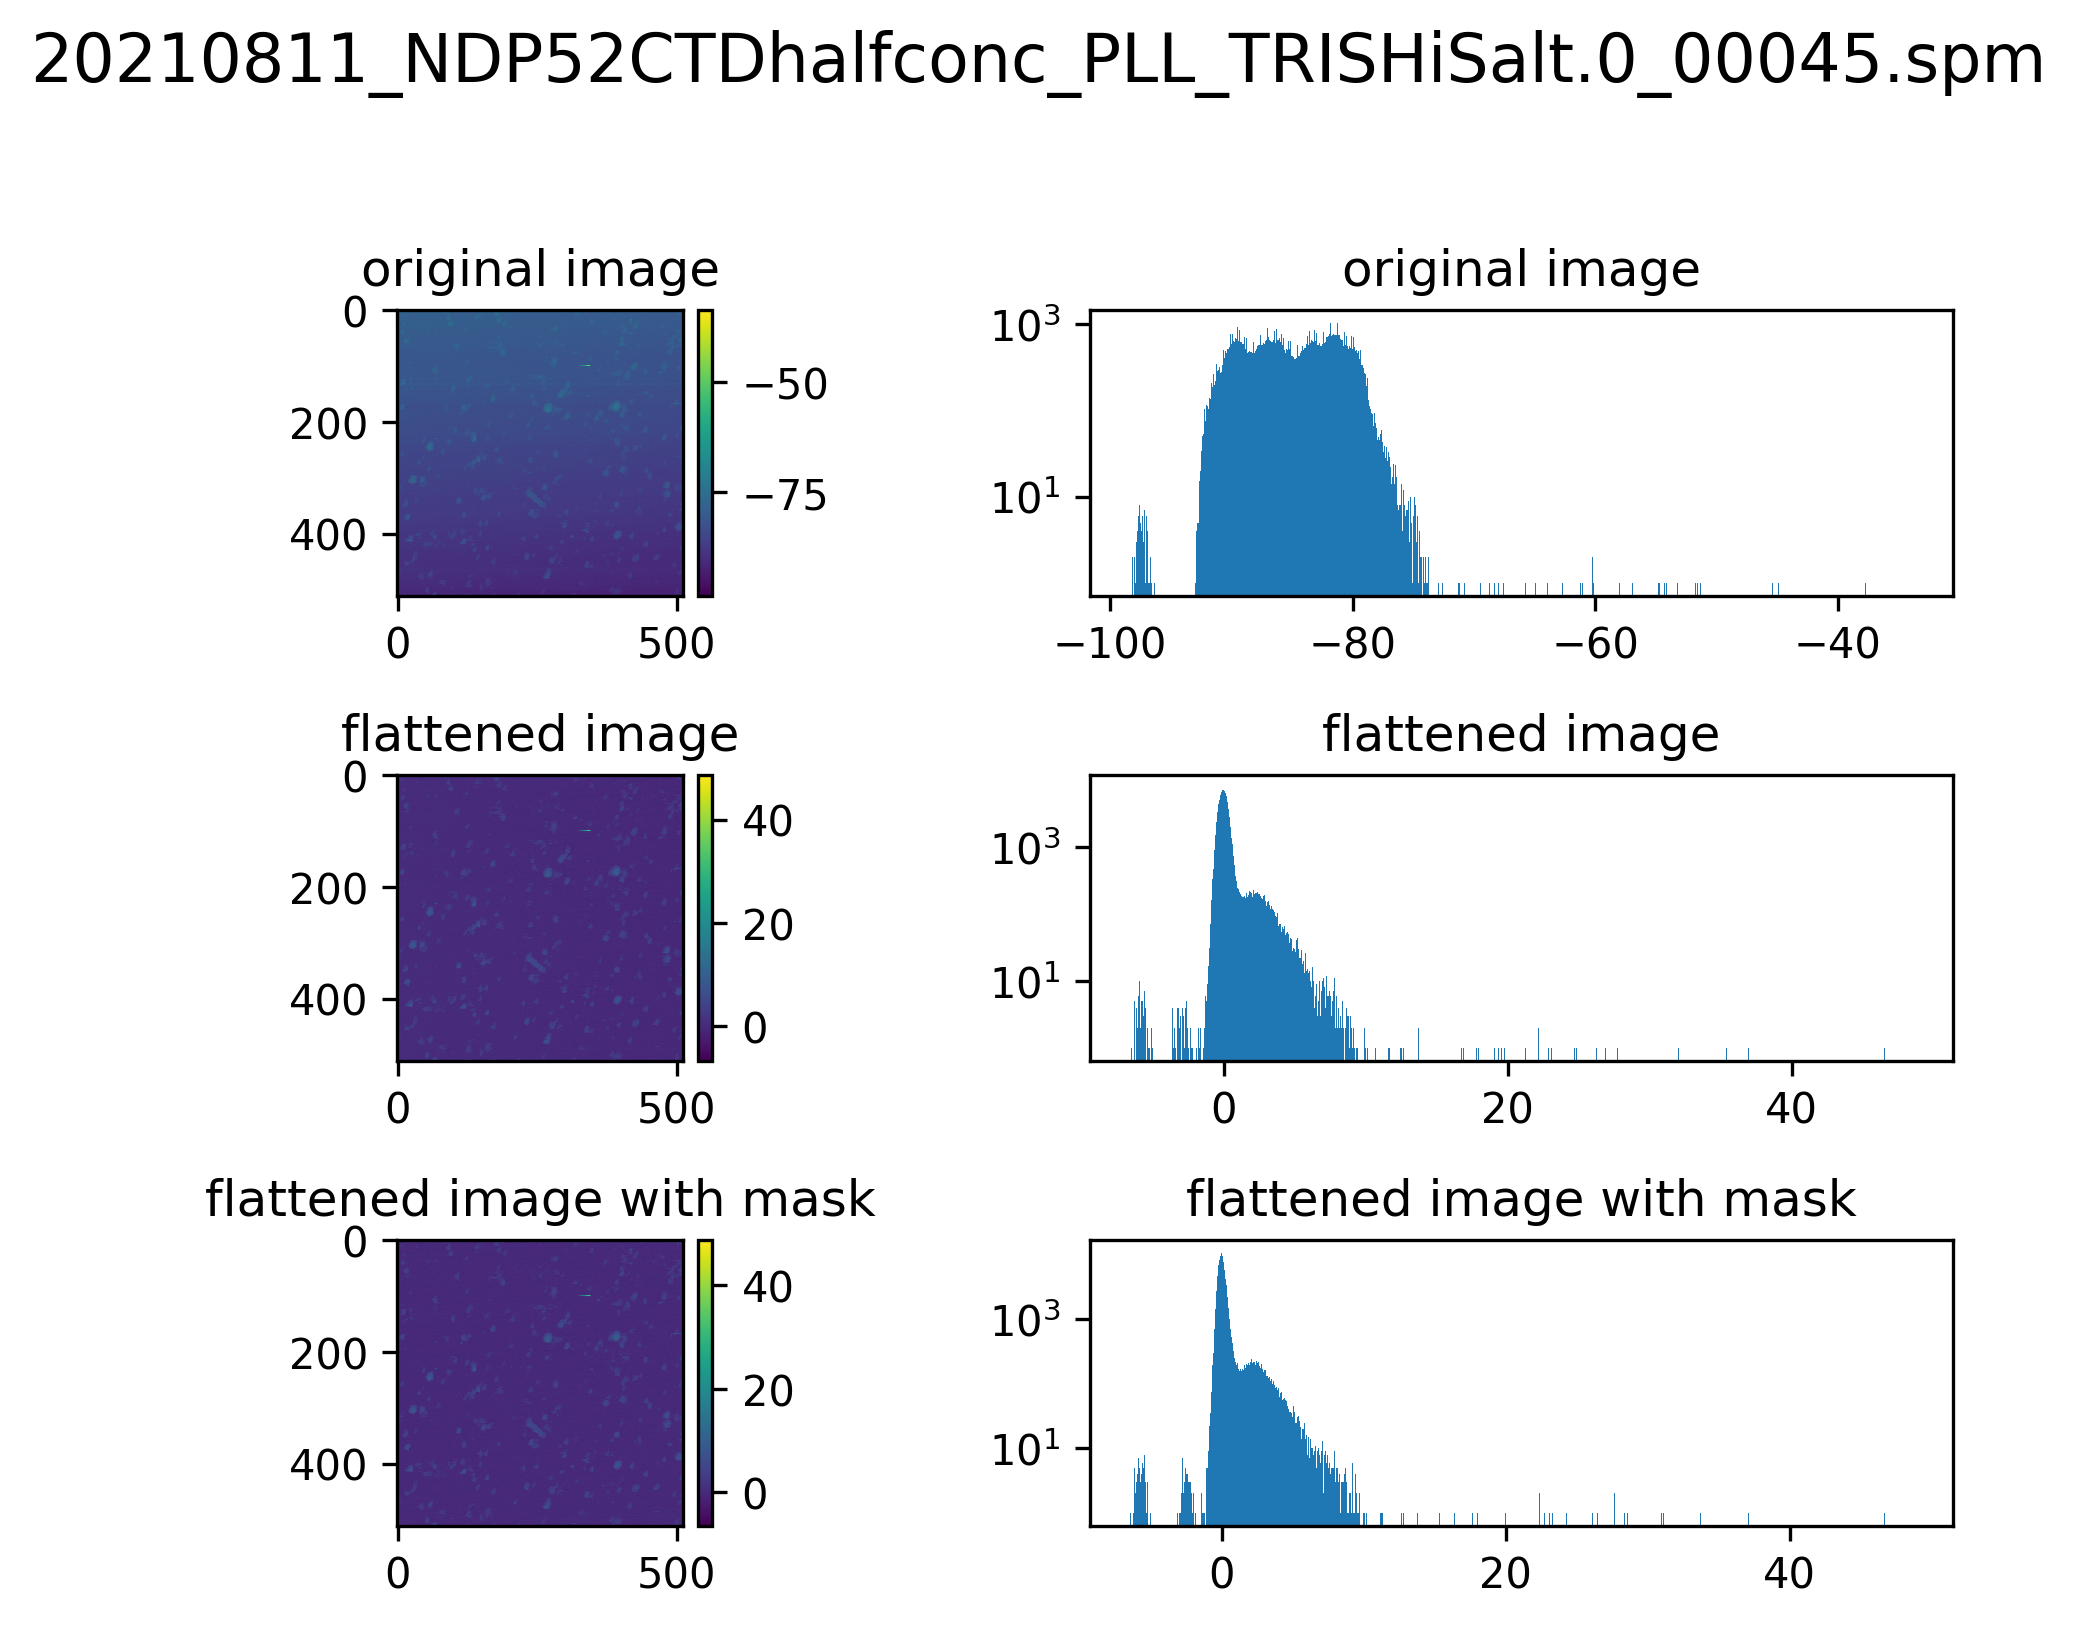

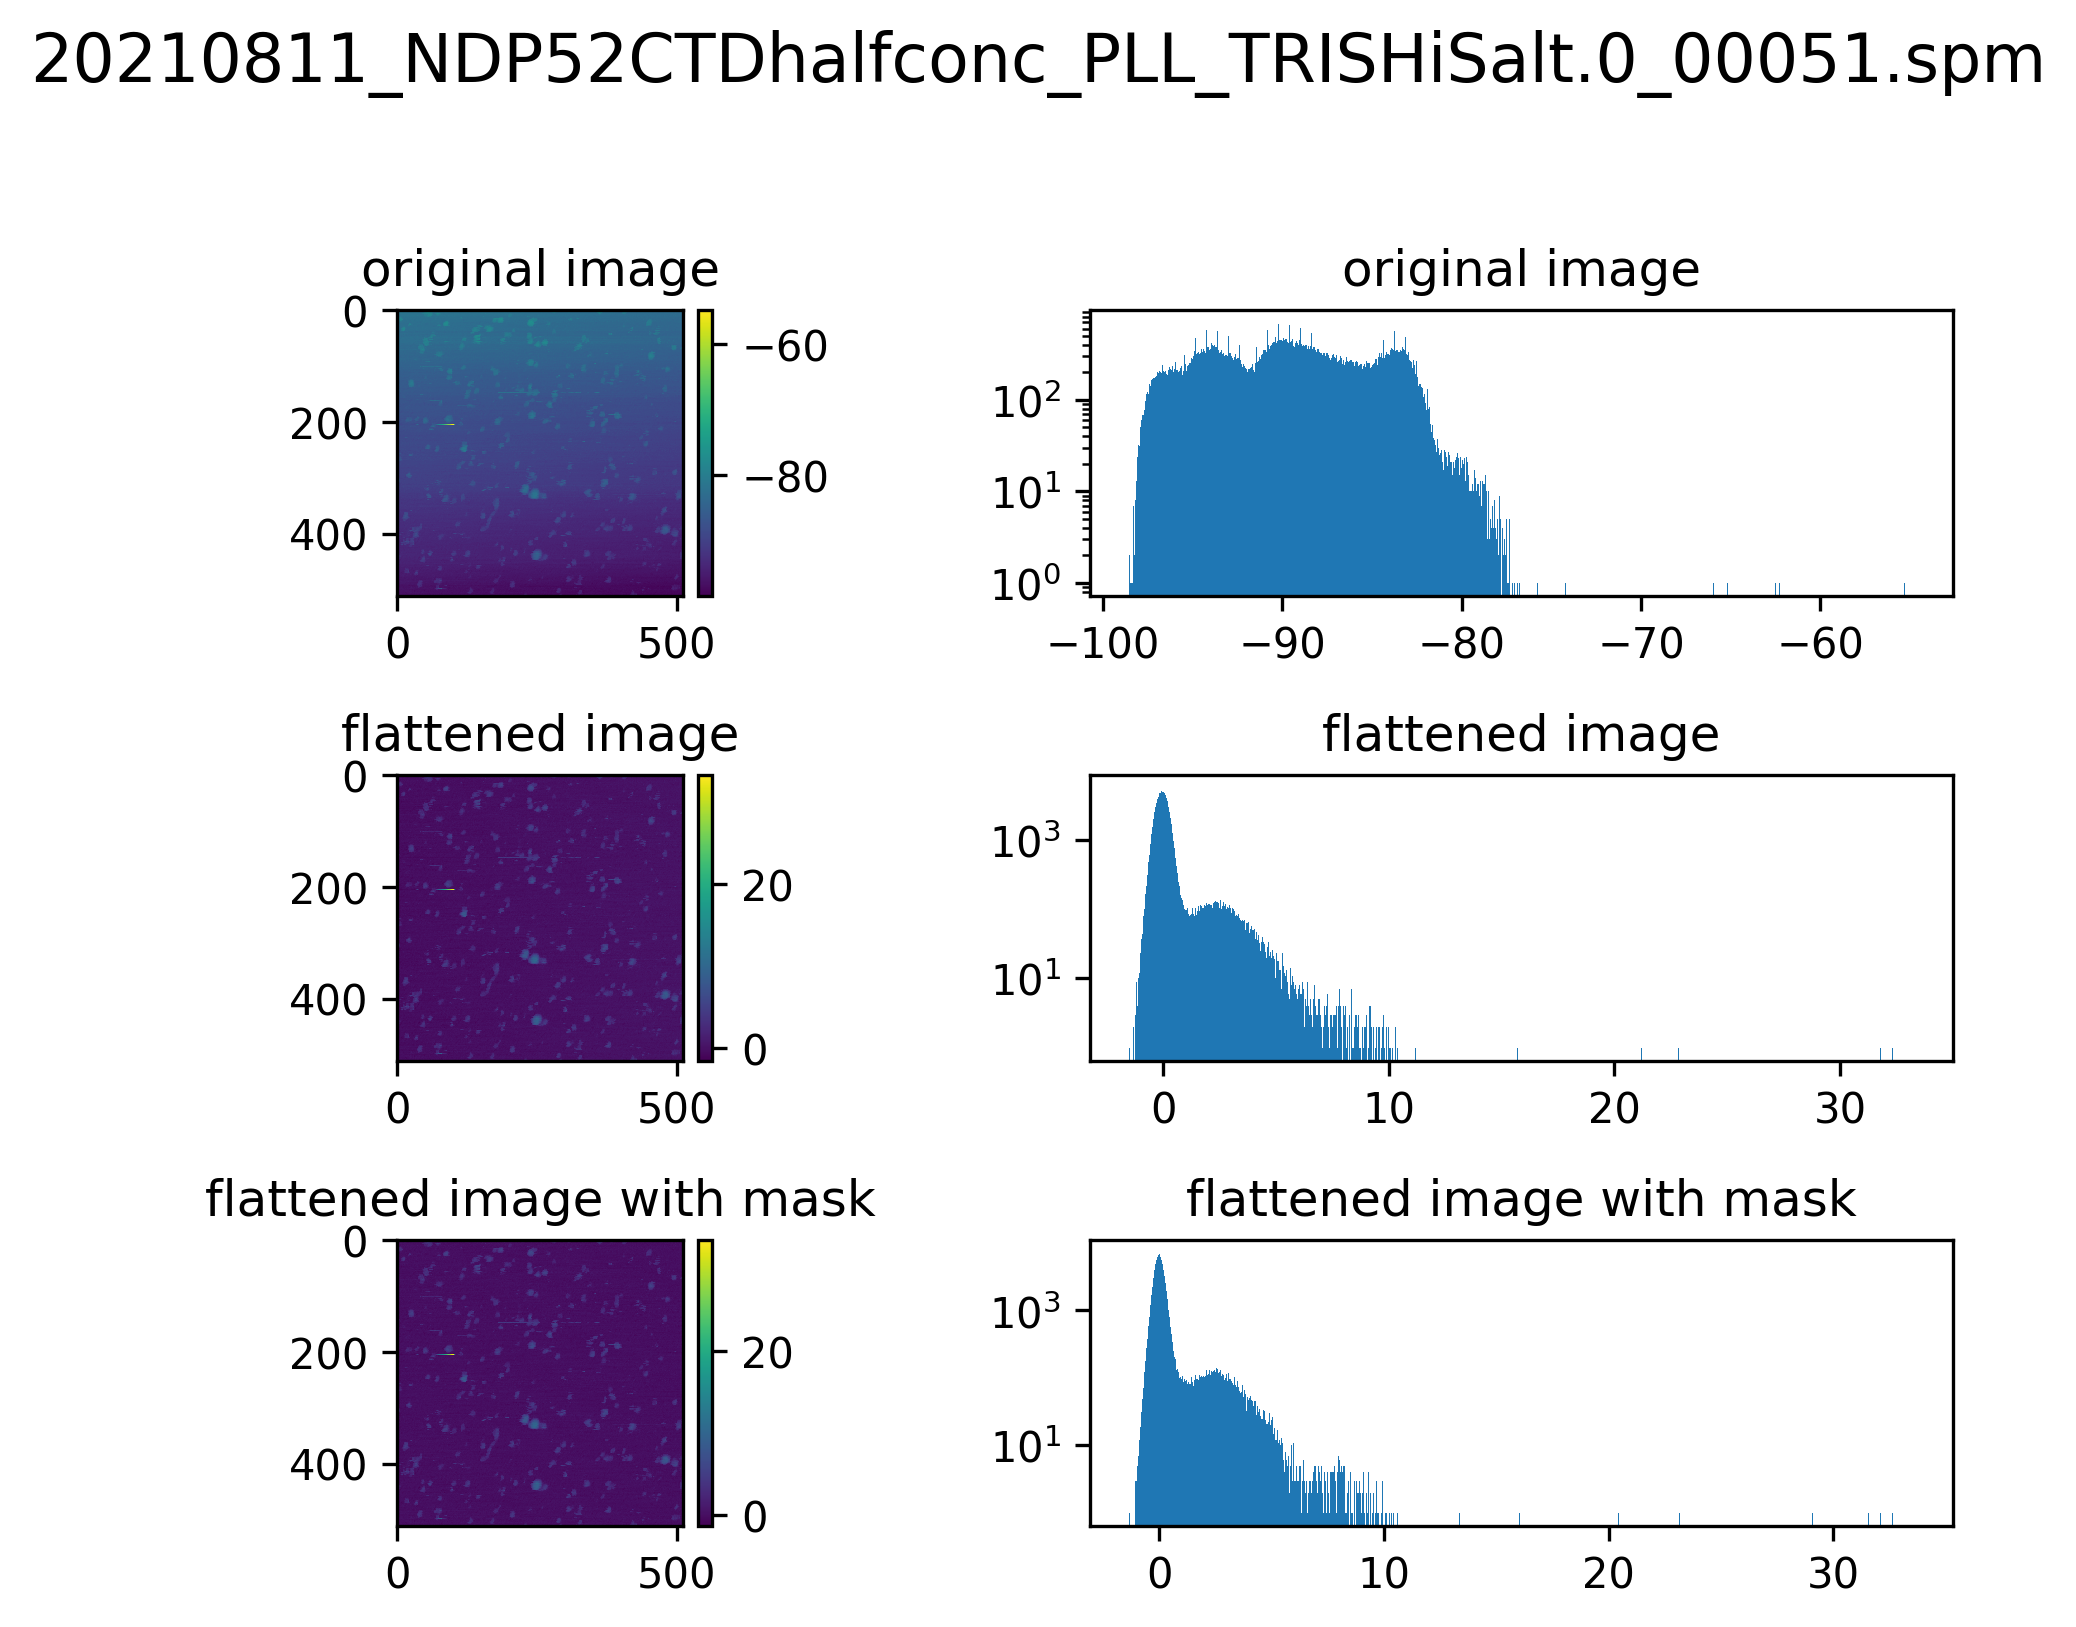

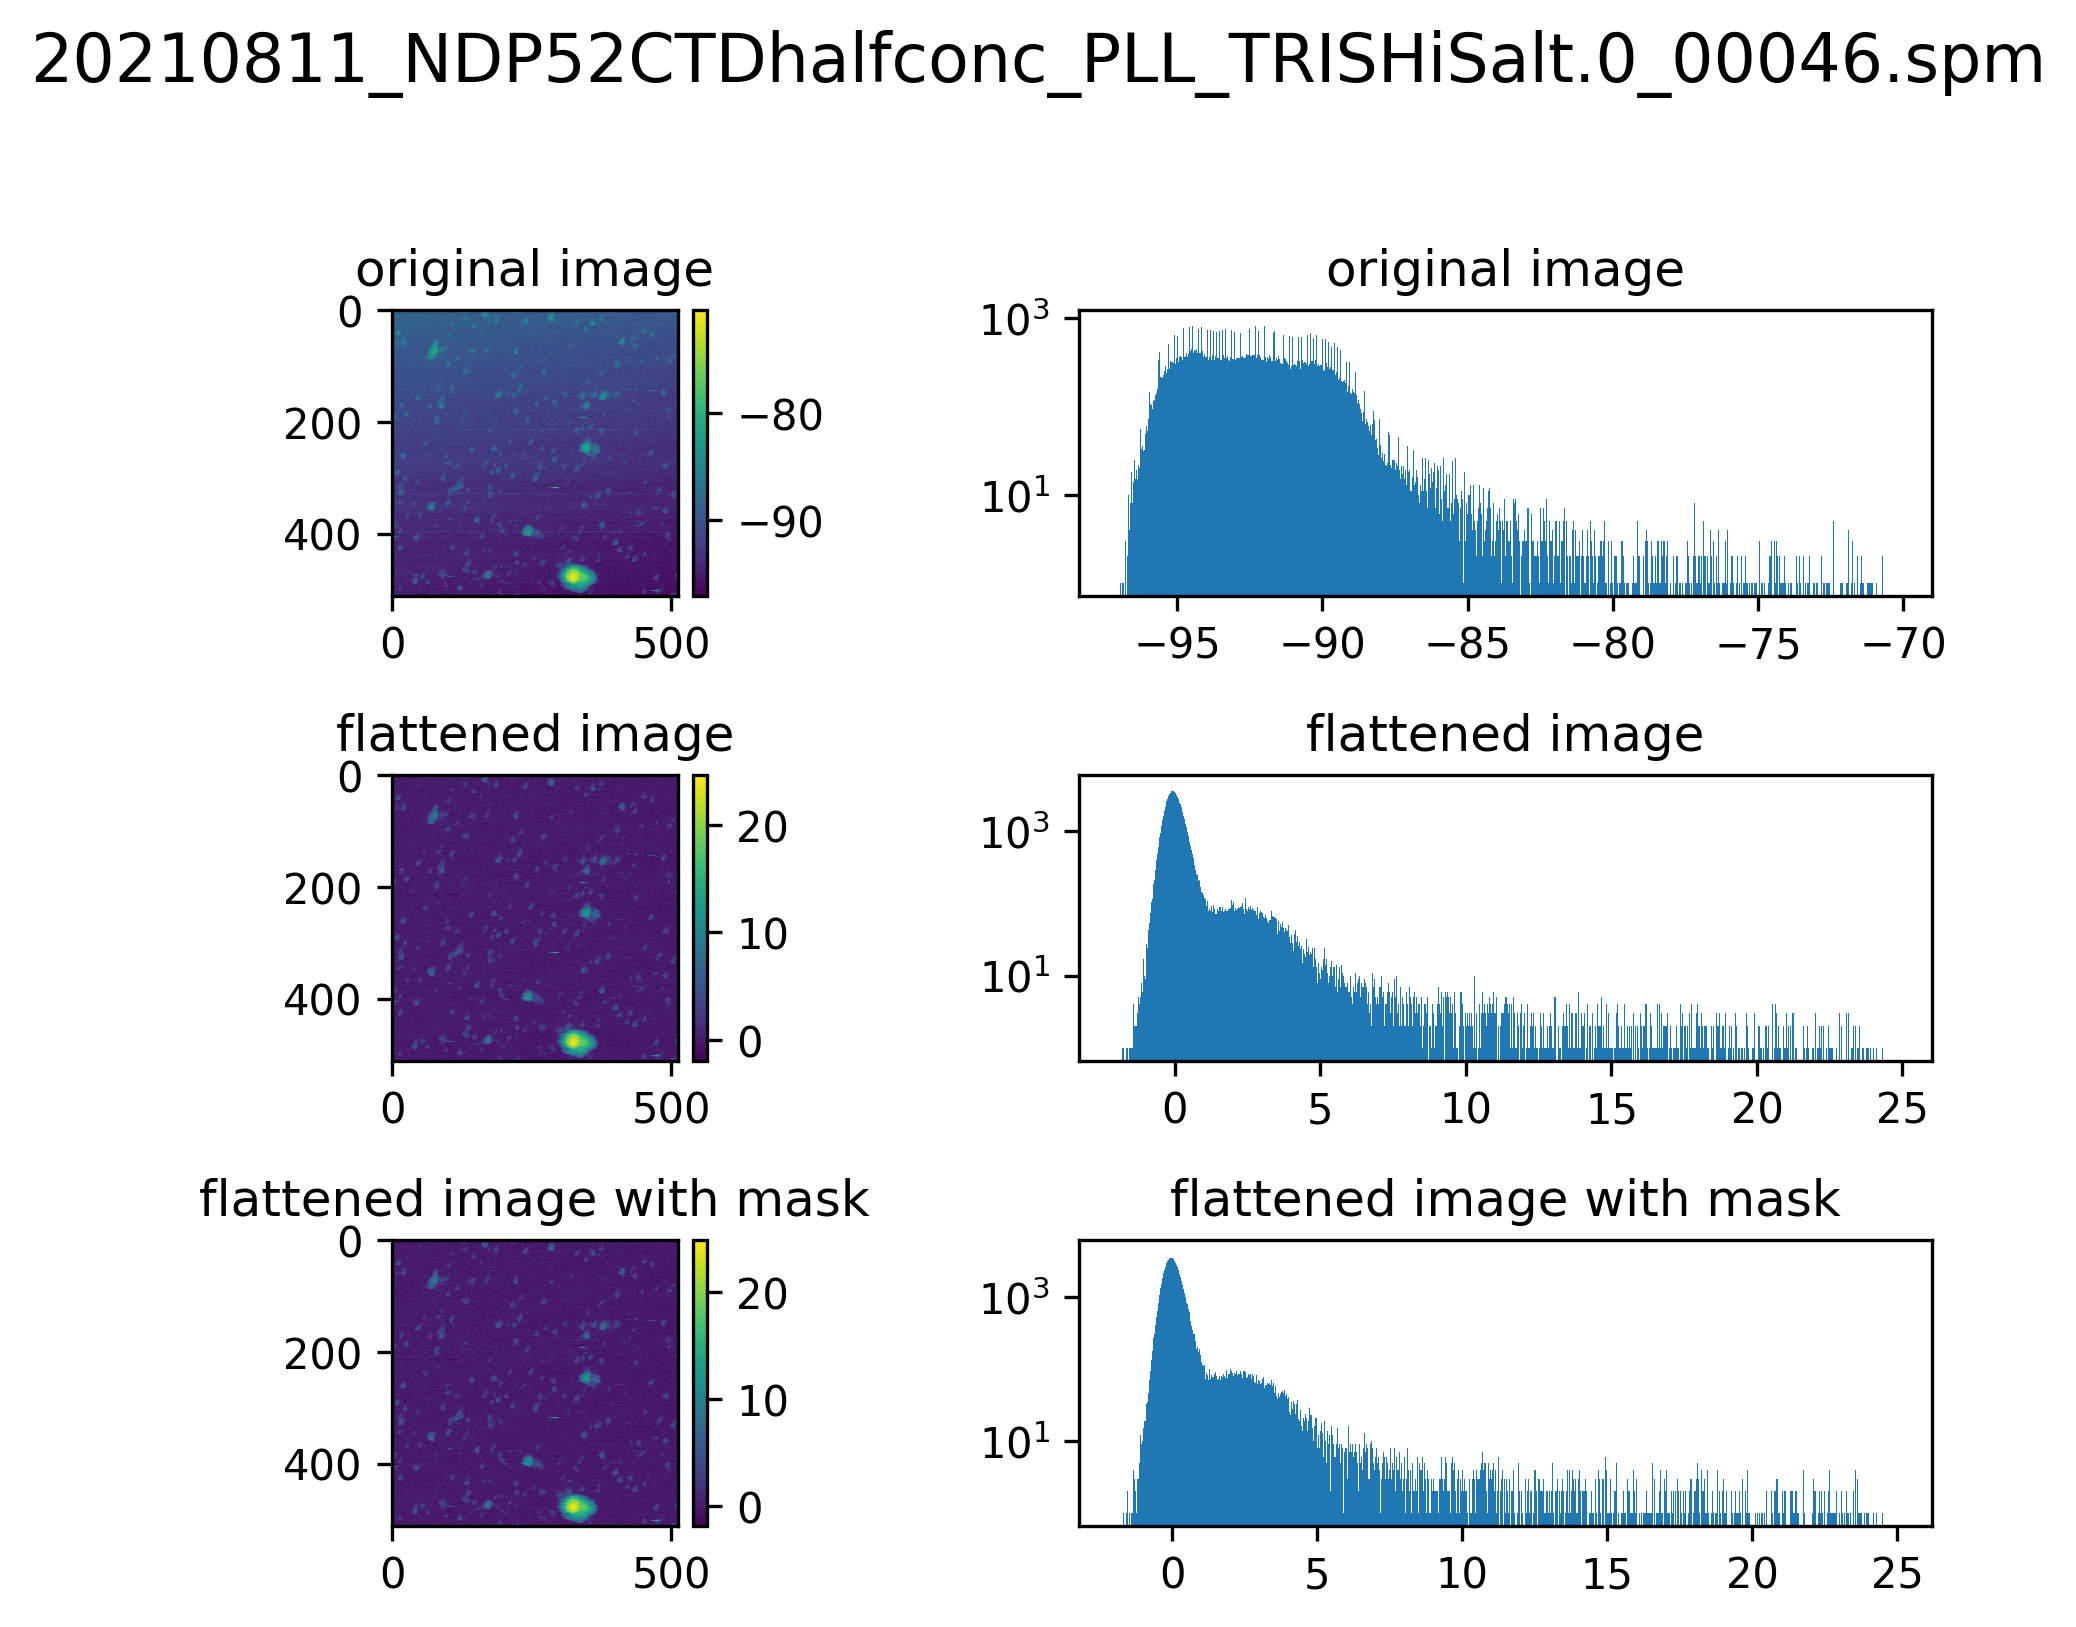

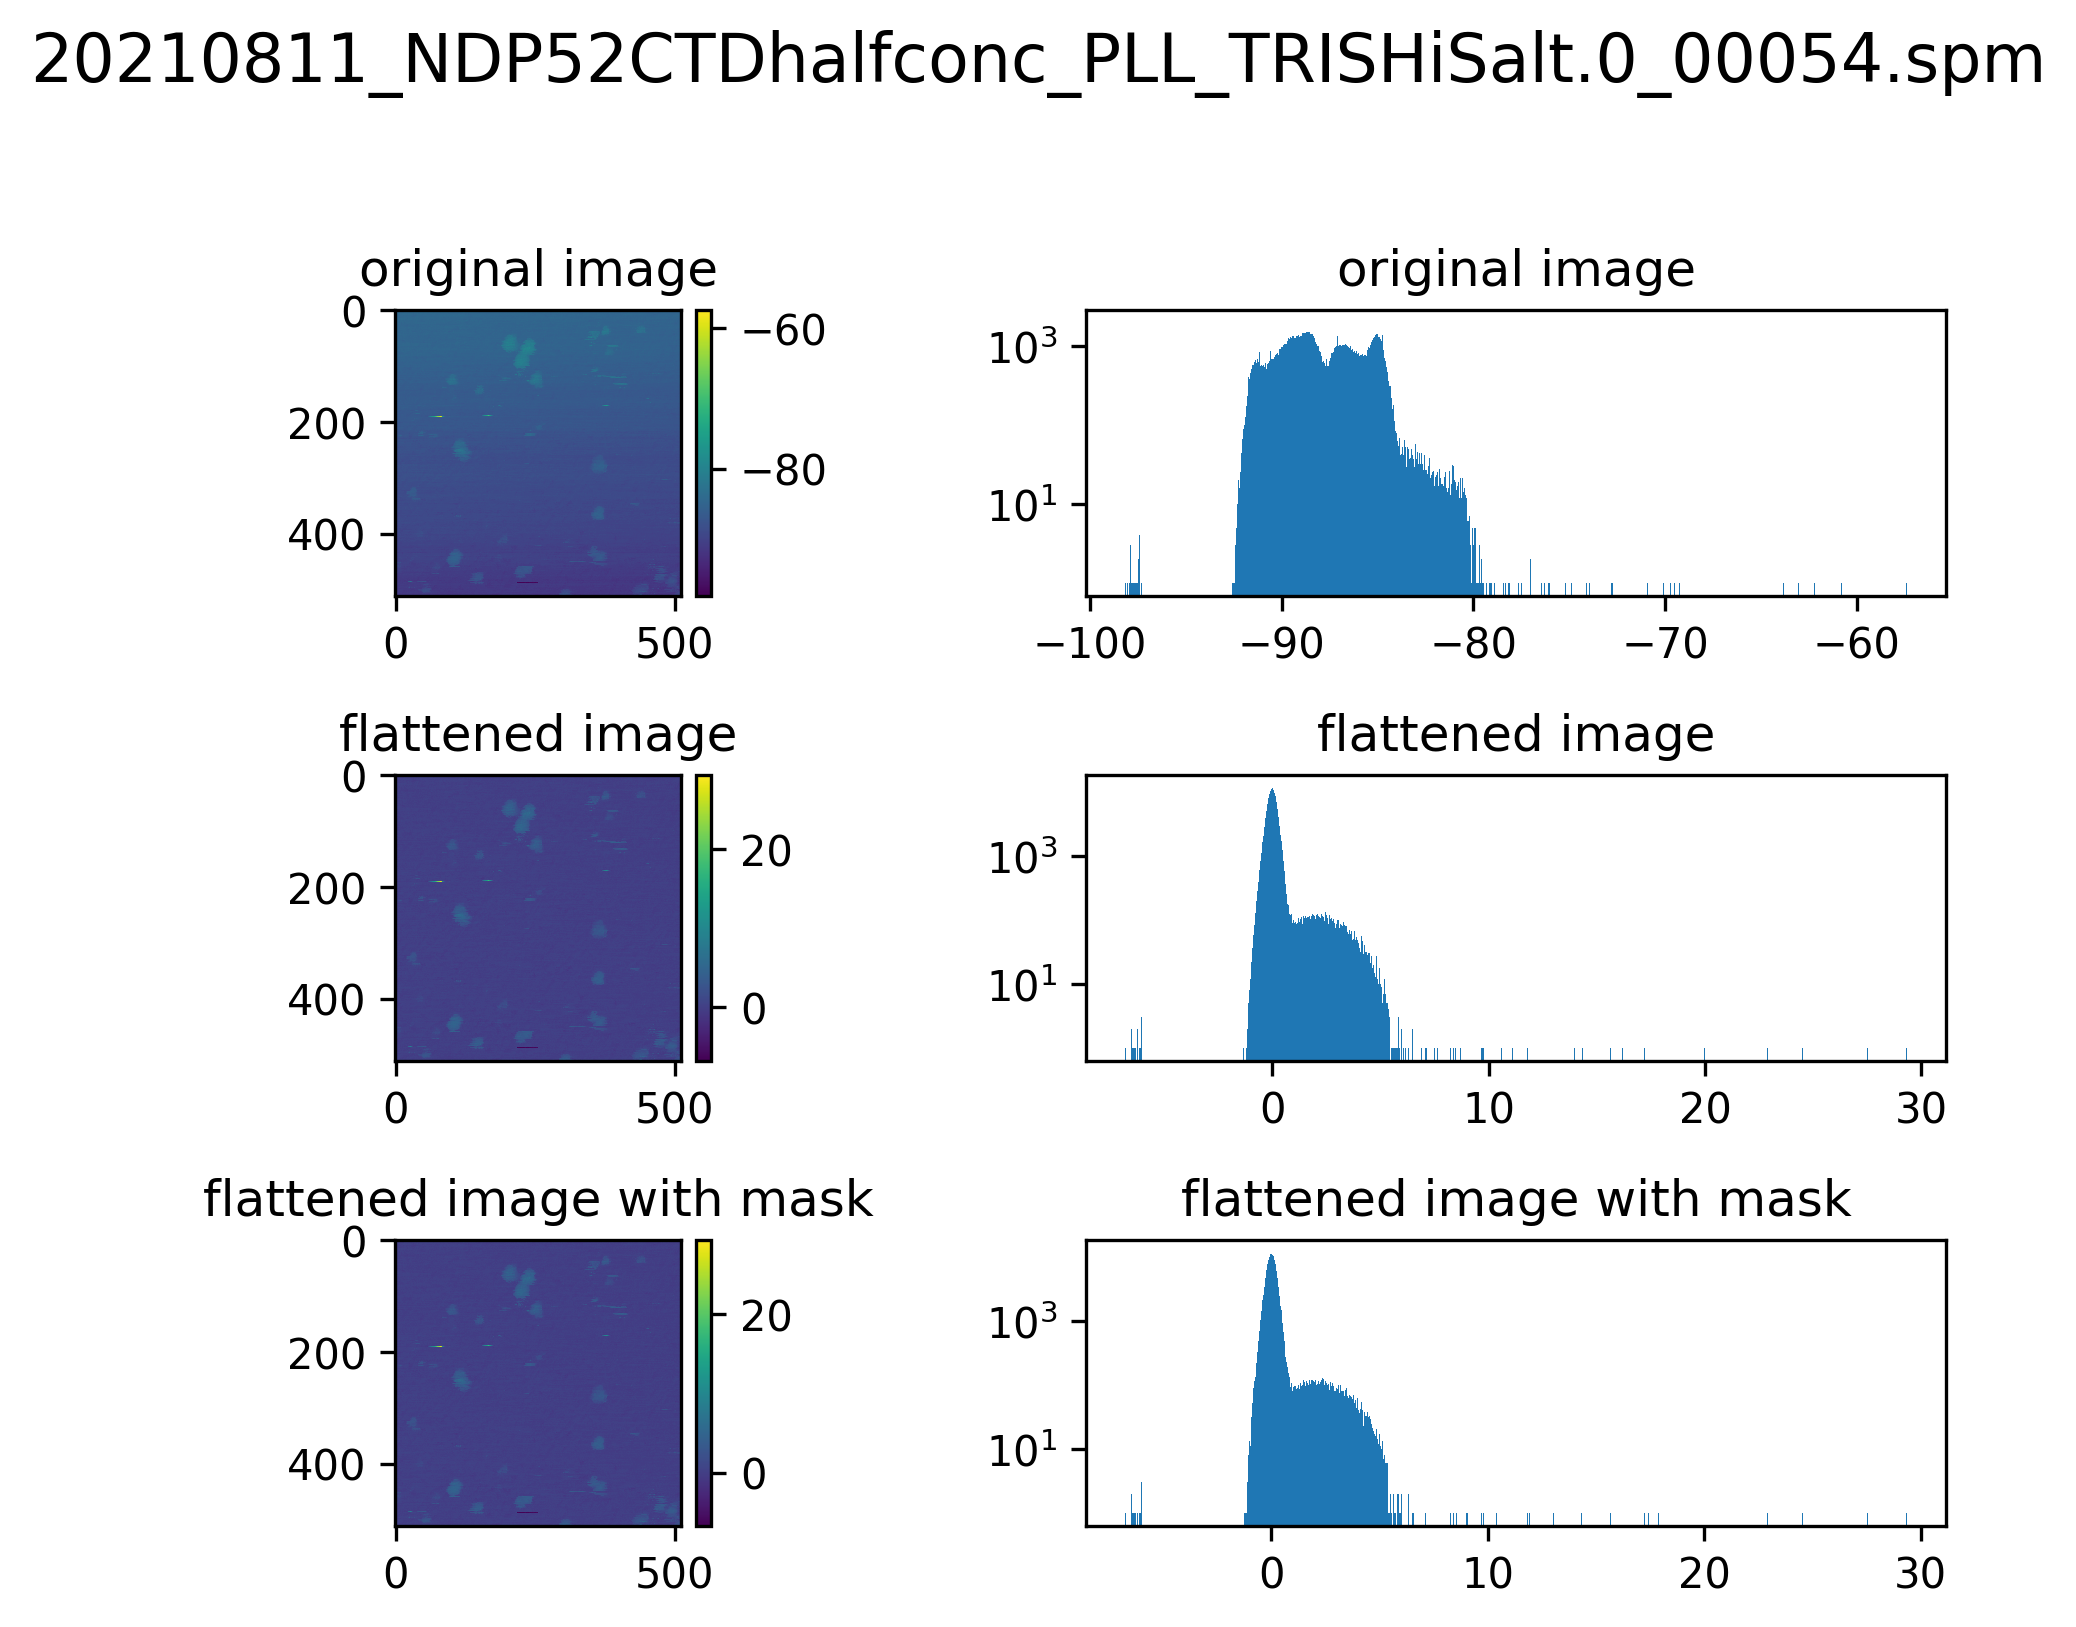

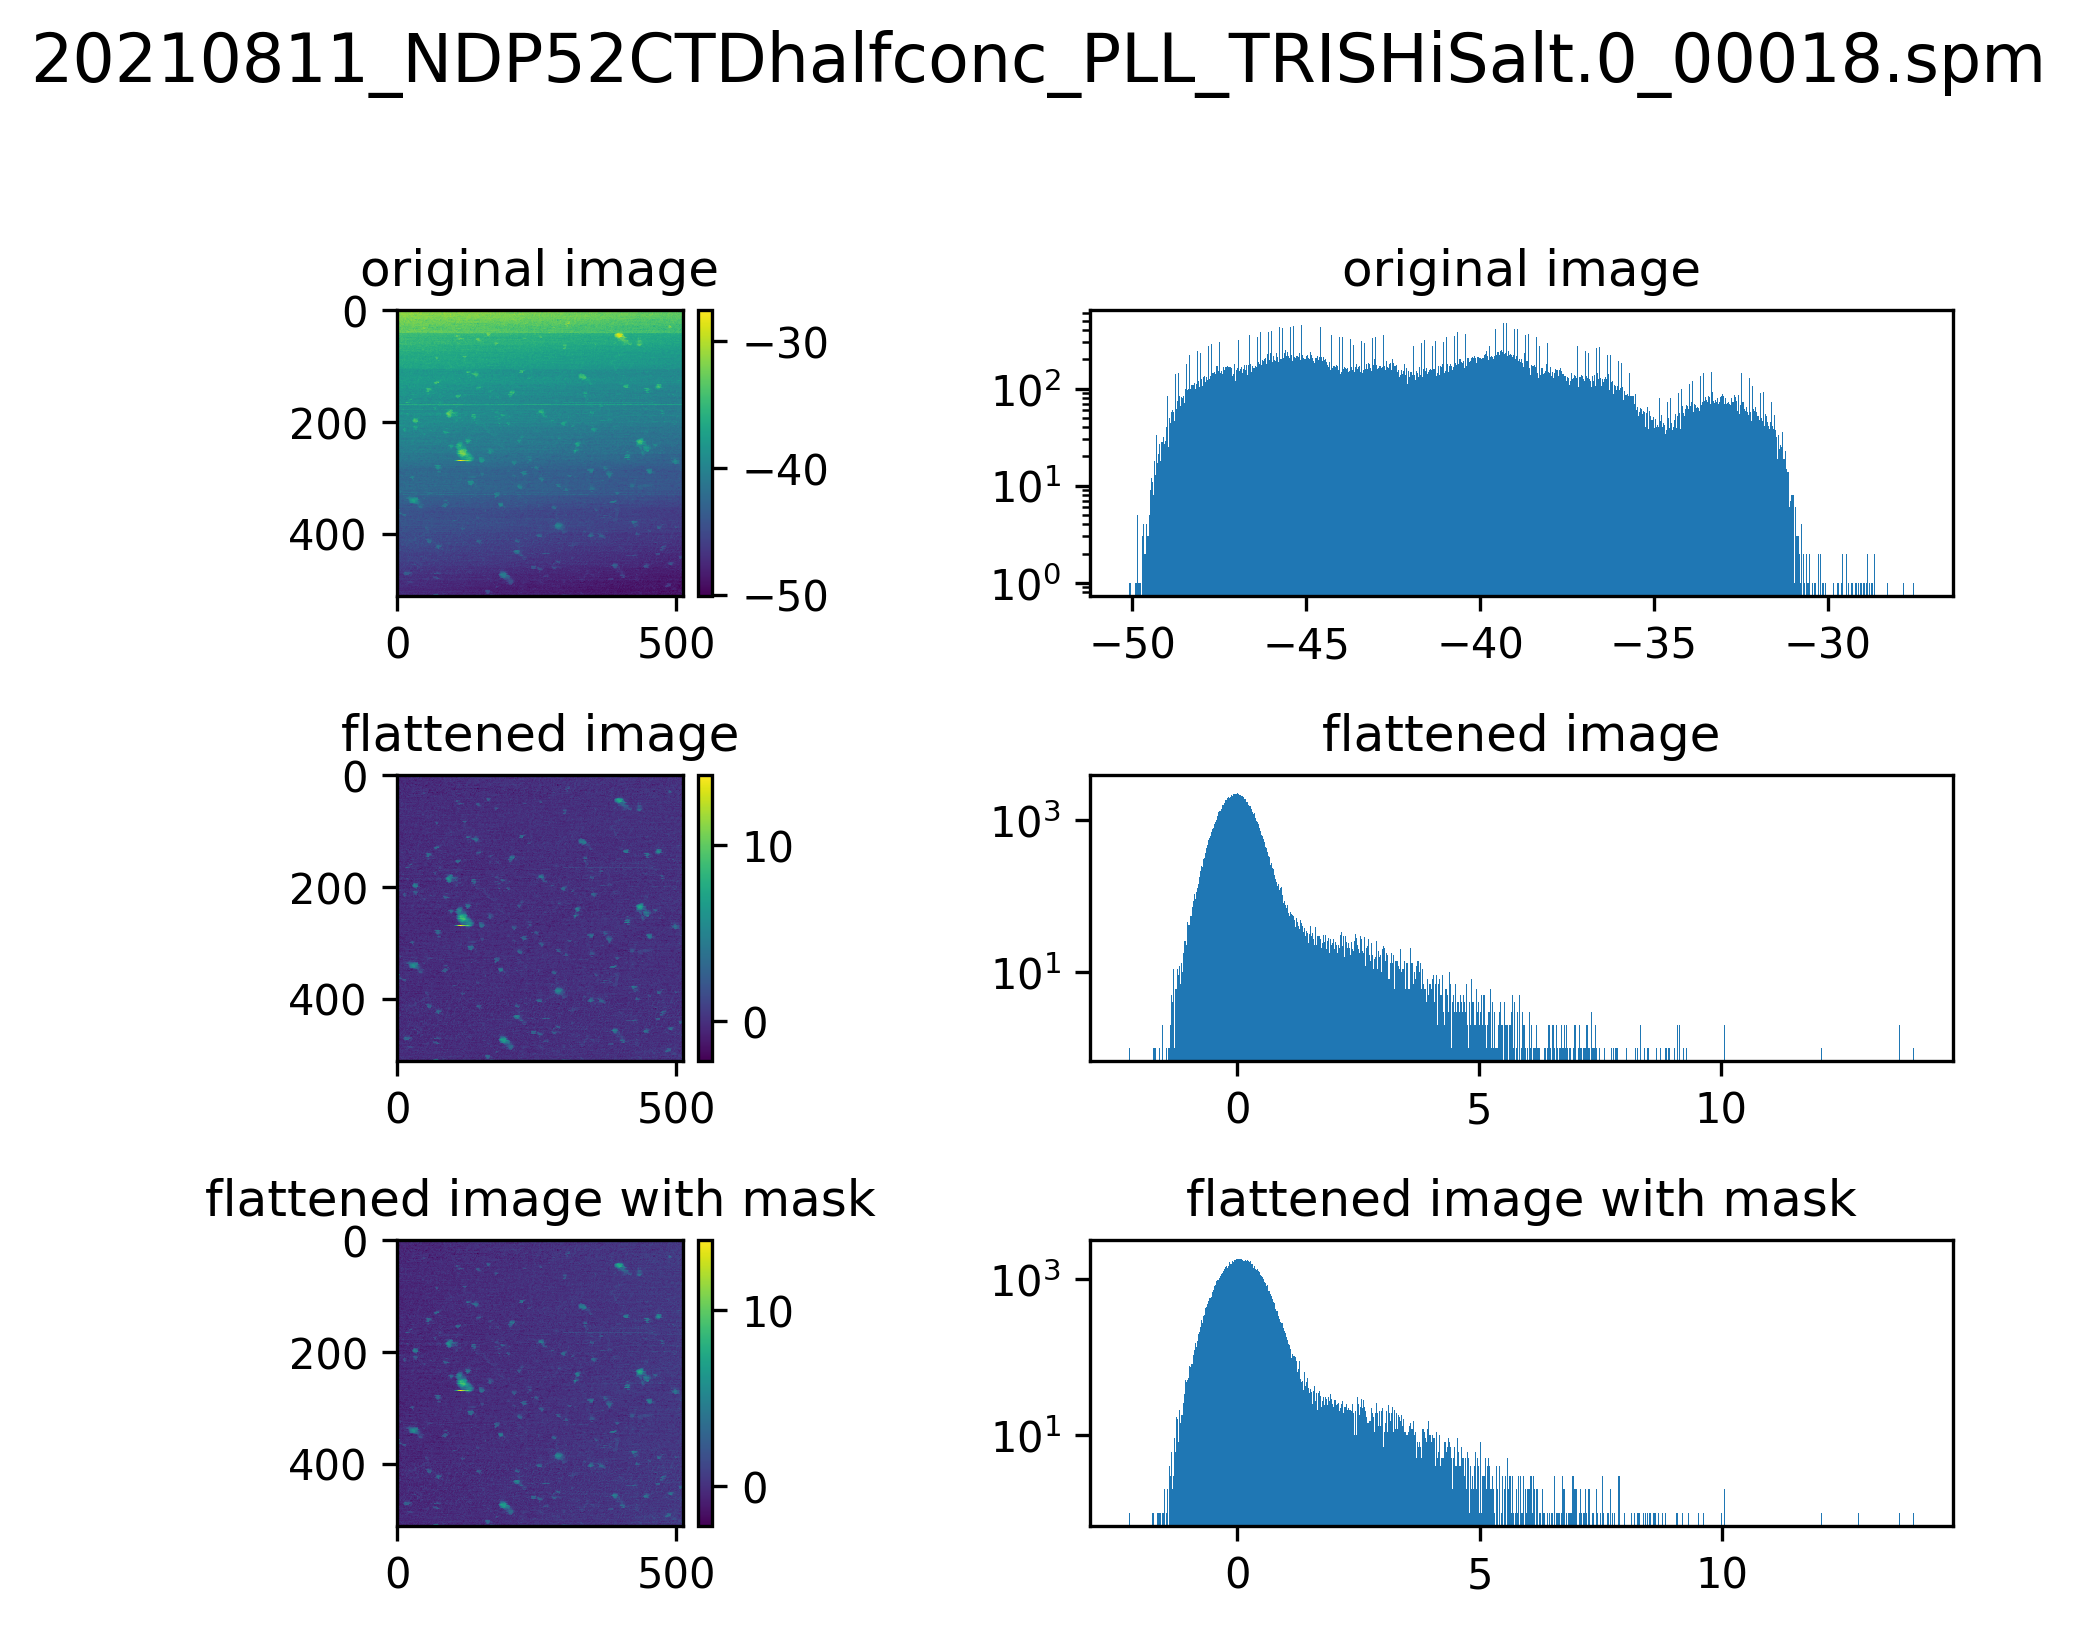

In [5]:
# Load data
mpl.rcParams['figure.dpi'] = 300
print(f'pySPM version: {pySPM.__version__}')

for path in Path('data/Protiens/').rglob('*.spm'):
    filename = path.name
    superdir = path.parents[1]
    dir = path.parents[0]
    savedir = superdir / (dir.name + '_output')
    Path.mkdir(savedir, exist_ok=True, parents=True)
    scan = pySPM.Bruker(path)
    topo = scan.get_channel('Height')
    data = topo.pixels

    flatten(data, filename, save_path=savedir)
    # plt.imshow(data)